In [26]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Until now, I've encountered two types of data objects in the Pandas library—DataFrames and Series, and here is a [Scaler Topics article on core components of Pandas](https://www.scaler.com/topics/pandas/core-components-of-pandas/), confirming that these two are the important ones (for single-dimensional, and two-dimensional data respectively), apart from a third object type, `Panel` (for three-dimensional data).

Here's a micro-article attempting to list the organisation of files in Pandas' architecture: [Discover Pandas Library Architecture – File Hierarchy in Pandas](https://data-flair.training/blogs/pandas-library-architecture/)


In [72]:
ratings_df = pd.read_csv("./anime-ratings-matrix-factorization-v-10/anime ratings dataset/rating.csv")

In [8]:
ratings_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [46]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [44]:
ratings_df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,7813737.0,36727.956745,20997.946119,1.0,18974.0,36791.0,54757.0,73516.0
anime_id,7813737.0,8909.072104,8883.949636,1.0,1240.0,6213.0,14093.0,34519.0
rating,7813737.0,6.144030,3.727800,-1.0,6.0,7.0,9.0,10.0


In [71]:
pd.value_counts(ratings_df['rating']).to_frame().T

/var/folders/s7/f5s_pst90jb362j0h7p5ypy00000gn/T/ipykernel_45421/1842115830.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(ratings_df['rating']).to_frame().T


rating,8,-1,7,9,10,6,5,4,3,2,1
count,1646019,1476496,1375287,1254096,955715,637775,282806,104291,41453,23150,16649


(array([1476496.,       0.,   16649.,   23150.,   41453.,  104291.,
         282806.,  637775., 1375287., 1646019., 1254096.,  955715.]),
 array([-1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,
         9.5, 10.5]),
 <BarContainer object of 12 artists>)

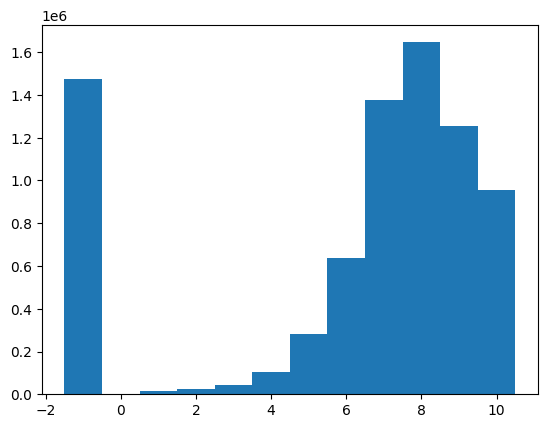

In [34]:
plt.hist(ratings_df['rating'], bins=[i-0.5 for i in range(-1,12)])

In [68]:
print( ratings_df.isna().sum() , "\n")
print( type(ratings_df.isna().sum()) )

user_id     0
anime_id    0
rating      0
dtype: int64 

<class 'pandas.core.series.Series'>


In [61]:
ratings_df.isna().sum().to_frame()

,0
user_id,0
anime_id,0
rating,0
